### Needed imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt


### Read in the data

In [3]:
with open('datasets/goblet_book.txt', 'r') as f:
    #Read the text file
    book_data = f.read()

    #Find the unique characters in the book and the length K
    book_chars = sorted(set(book_data))
    K = len(book_chars)

    #Create dictionaries for character to index and index to character conversion
    char_to_ind = {char: i for i, char in enumerate(book_chars)}
    ind_to_char = {i: char for i, char in enumerate(book_chars)}


''' convert a sequence of characters into a sequence of vectors 
    of one-hot encodings and vice versa
'''
def char_seq_to_one_hot(char_seq, char_to_ind, K):
    N = len(char_seq)
    one_hot_seq = np.zeros((K, N))
    for i, char in enumerate(char_seq):
        one_hot_seq[char_to_ind[char], i] = 1
    return one_hot_seq

def one_hot_seq_to_char_seq(one_hot_seq, ind_to_char):
    N = one_hot_seq.shape[1]
    char_seq = ''.join([ind_to_char[np.argmax(one_hot_seq[:, i])] for i in range(N)])
    return char_seq

# Example usage:
char_seq = 'hello'
one_hot_seq = char_seq_to_one_hot(char_seq, char_to_ind, K)
decoded_char_seq = one_hot_seq_to_char_seq(one_hot_seq, ind_to_char)

print(decoded_char_seq)  # Should print 'hello'






hello


### Set hyper-parameters & initialize the RNN’s parameters

In [15]:
import numpy as np

class RNN:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.1, seq_length=25, sigma=0.01):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.seq_length = seq_length
        
        self.b = np.zeros((hidden_dim, 1))
        self.c = np.zeros((output_dim, 1))
        
        self.U = np.random.randn(hidden_dim, input_dim) / np.sqrt(input_dim)
        self.W = np.random.randn(hidden_dim, hidden_dim) / np.sqrt(hidden_dim)
        self.V = np.random.randn(output_dim, hidden_dim) / np.sqrt(hidden_dim)

# Set hyperparameters
m = 100
eta = 0.1
seq_length = 25

# Initialize the RNN
rnn = RNN(K, m, K, learning_rate=eta, seq_length=seq_length)


### Synthesize text from your randomly initialized RNN

In [5]:
def synthesize_sequence(rnn, h0, x0, n):
    x = x0
    h = h0
    Y = np.zeros((rnn.output_dim, n))

    for t in range(n):
        h = np.tanh(np.dot(rnn.U, x) + np.dot(rnn.W, h) + rnn.b)
        o = np.dot(rnn.V, h) + rnn.c
        p = np.exp(o) / np.sum(np.exp(o))

        ix = np.random.choice(range(rnn.output_dim), p=p.ravel())
        x_next = np.zeros((rnn.input_dim, 1))
        x_next[ix] = 1

        Y[:, t] = x_next.ravel()
        x = x_next

    return Y

# Example usage:
h0 = np.zeros((m, 1))
x0 = char_seq_to_one_hot('.', char_to_ind, K)
n = 100

Y = synthesize_sequence(rnn, h0, x0, n)
char_seq_synthesized = one_hot_seq_to_char_seq(Y, ind_to_char)

print(char_seq_synthesized)


}6!b"b4;CP(o,^}yJ}4Y?Qf7WuJ
jG_
	P
AiK	F^Pw•ei}1cbE74m}HDNkfaxZcu^_l!dc(;mi-a?:GTvif.mMe.my:
dhiZG)s


### Implement the forward & backward pass of back-prop

In [8]:
#forwards pass
def forward_pass(rnn, X, Y, h0):
    n = X.shape[1]
    h, o, p = {}, {}, {}
    h[-1] = np.copy(h0)
    loss = 0

    for t in range(n):
        h[t] = np.tanh(np.dot(rnn.U, X[:, t:t+1]) + np.dot(rnn.W, h[t-1]) + rnn.b)
        o[t] = np.dot(rnn.V, h[t]) + rnn.c
        p[t] = np.exp(o[t]) / np.sum(np.exp(o[t]))
        loss += -np.log(p[t][Y[:, t].argmax(), 0])

    return loss, h, p

#backwards pass
def backward_pass(rnn, X, Y, h, p):
    grads = {
        'U': np.zeros_like(rnn.U),
        'W': np.zeros_like(rnn.W),
        'V': np.zeros_like(rnn.V),
        'b': np.zeros_like(rnn.b),
        'c': np.zeros_like(rnn.c)
    }

    dh_next = np.zeros_like(h[0])
    n = X.shape[1]

    for t in reversed(range(n)):
        dL_do = np.copy(p[t])
        dL_do[Y[:, t].argmax()] -= 1

        grads['V'] += np.dot(dL_do, h[t].T)
        grads['c'] += dL_do

        dL_dh = np.dot(rnn.V.T, dL_do) + dh_next
        dL_da = (1 - h[t] * h[t]) * dL_dh

        grads['U'] += np.dot(dL_da, X[:, t:t+1].T)
        grads['W'] += np.dot(dL_da, h[t-1].T)
        grads['b'] += dL_da

        dh_next = np.dot(rnn.W.T, dL_da)

    return grads

#gradient clipping
def clip_gradients(grads, threshold=5):
    for k in grads:
        grads[k] = np.clip(grads[k], -threshold, threshold)
    return grads

# Example usage:
X_chars = book_data[:seq_length]
Y_chars = book_data[1:seq_length + 1]

X = char_seq_to_one_hot(X_chars, char_to_ind, K)
Y = char_seq_to_one_hot(Y_chars, char_to_ind, K)

h0 = np.zeros((m, 1))

loss, h, p = forward_pass(rnn, X, Y, h0)
grads = backward_pass(rnn, X, Y, h, p)
grads = clip_gradients(grads)

print(loss)



109.56097980112816


### Train your RNN using AdaGrad

In [10]:
def train_rnn(rnn, book_data, char_to_ind, ind_to_char, n_epochs=7):
    K = rnn.output_dim
    seq_length = rnn.seq_length

    iter_per_epoch = len(book_data) // seq_length
    n_updates = n_epochs * iter_per_epoch

    smooth_loss = -np.log(1.0 / K) * seq_length
    hprev = np.zeros((rnn.hidden_dim, 1))
    ada_params = {k: np.zeros_like(getattr(rnn, k)) for k in ['U', 'W', 'V']}

    e = 0
    for update_step in range(n_updates):
        if e == 0 or e + seq_length + 1 > len(book_data):
            e = 1
            hprev = np.zeros((rnn.hidden_dim, 1))

        X_chars = book_data[e - 1 : e - 1 + seq_length]
        Y_chars = book_data[e : e + seq_length]

        X = char_seq_to_one_hot(X_chars, char_to_ind, K)
        Y = char_seq_to_one_hot(Y_chars, char_to_ind, K)

        loss, h, p = forward_pass(rnn, X, Y, hprev)
        grads = backward_pass(rnn, X, Y, h, p)
        grads = clip_gradients(grads)

        for k in ada_params.keys():
            ada_params[k] += grads[k] * grads[k]
            updated_param = getattr(rnn, k) - rnn.learning_rate * grads[k] / (np.sqrt(ada_params[k]) + 1e-8)
            setattr(rnn, k, updated_param)

        smooth_loss = 0.999 * smooth_loss + 0.001 * loss

        if update_step % 10000 == 0:
            print("Smooth loss at step {}: {}".format(update_step, smooth_loss))

        if update_step % 100000 == 0:
            Y_synthesized = synthesize_sequence(rnn, hprev, X[:, :1], 200)
            synthesized_seq = one_hot_seq_to_char_seq(Y_synthesized, ind_to_char)
            print("Synthesized text:\n", synthesized_seq)

        e += seq_length

# Call the train_rnn function to train the RNN
train_rnn(rnn, book_data, char_to_ind, ind_to_char, n_epochs=7)


Smooth loss at step 0: 109.50769996712769
Synthesized text:
 A b'yu ( p r u u v u'v u v'u v'm m n'v'm u u R R R R R 'R R R R R R LR R T R R T  R  v'm f u u u R A A T R R  R R R R R K T R R R SG n u v'v'v'v'v'm v'v'm v u v u u u v u n u n u u u u u m m u u v u u
Smooth loss at step 10000: 57.520318305925336
Smooth loss at step 20000: 54.70043569800328
Smooth loss at step 30000: 53.510592355116785
Smooth loss at step 40000: 52.45113146348167
Smooth loss at step 50000: 53.335757774138365
Smooth loss at step 60000: 52.2696563057034
Smooth loss at step 70000: 51.92208880514807
Smooth loss at step 80000: 50.666623927838366
Smooth loss at step 90000: 51.09237418652072
Smooth loss at step 100000: 51.96534404034018
Synthesized text:
 onturd loolled woud sour Prevint tith ear jusked lump at Harry,"  phe fword wizirs puching youpho and sturs nomeccin, leo nog Bloovin he don intuptertwan I tUne.
Wenowlins furollat in some and seet a 
Smooth loss at step 110000: 50.346799692816305
Smooth loss at st

include a graph of the smooth loss function for a longish training
run (at least 2 epochs)

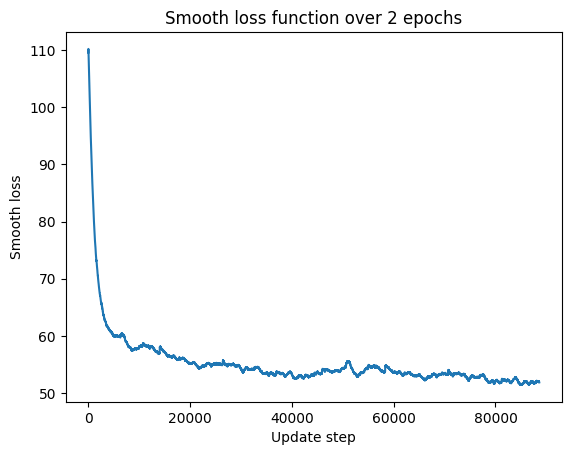

In [12]:
import matplotlib.pyplot as plt

def train_rnn(rnn, book_data, char_to_ind, ind_to_char, n_epochs=7):
    K = rnn.output_dim
    seq_length = rnn.seq_length

    iter_per_epoch = len(book_data) // seq_length
    n_updates = n_epochs * iter_per_epoch

    smooth_loss = -np.log(1.0 / K) * seq_length
    hprev = np.zeros((rnn.hidden_dim, 1))
    ada_params = {k: np.zeros_like(getattr(rnn, k)) for k in ['U', 'W', 'V']}

    e = 0
    smooth_losses = []
    for update_step in range(n_updates):
        if e == 0 or e + seq_length + 1 > len(book_data):
            e = 1
            hprev = np.zeros((rnn.hidden_dim, 1))

        X_chars = book_data[e - 1 : e - 1 + seq_length]
        Y_chars = book_data[e : e + seq_length]

        X = char_seq_to_one_hot(X_chars, char_to_ind, K)
        Y = char_seq_to_one_hot(Y_chars, char_to_ind, K)

        loss, h, p = forward_pass(rnn, X, Y, hprev)
        grads = backward_pass(rnn, X, Y, h, p)
        grads = clip_gradients(grads)

        for k in ada_params.keys():
            ada_params[k] += grads[k] * grads[k]
            updated_param = getattr(rnn, k) - rnn.learning_rate * grads[k] / (np.sqrt(ada_params[k]) + 1e-8)
            setattr(rnn, k, updated_param)

        smooth_loss = 0.999 * smooth_loss + 0.001 * loss
        smooth_losses.append(smooth_loss)

        #if update_step % 100 == 0:
            #print("Smooth loss at step {}: {}".format(update_step, smooth_loss))

        #if update_step % 500 == 0:
            #Y_synthesized = synthesize_sequence(rnn, hprev, X[:, :1], 200)
            #synthesized_seq = one_hot_seq_to_char_seq(Y_synthesized, ind_to_char)
            #print("Synthesized text:\n", synthesized_seq)

        e += seq_length

    return smooth_losses

# Call the train_rnn function to train the RNN and get smooth losses
smooth_losses = train_rnn(rnn, book_data, char_to_ind, ind_to_char, n_epochs=2)

# Plot the smooth loss function
plt.plot(smooth_losses)
plt.xlabel('Update step')
plt.ylabel('Smooth loss')
plt.title('Smooth loss function over 2 epochs')
plt.show()


Show the evolution of the text synthesized by your RNN during
training by including a sample of synthesized text (200 characters
long) before the first and before every 10,000th update steps when
you train for 100,000 update steps

In [14]:
import pickle

def train_rnn(rnn, book_data, char_to_ind, ind_to_char, n_updates=100000):
    K = rnn.output_dim
    seq_length = rnn.seq_length

    iter_per_epoch = len(book_data) // seq_length
    n_epochs = n_updates // iter_per_epoch

    smooth_loss = -np.log(1.0 / K) * seq_length
    hprev = np.zeros((rnn.hidden_dim, 1))
    ada_params = {k: np.zeros_like(getattr(rnn, k)) for k in ['U', 'W', 'V']}

    e = 0
    best_rnn = None
    lowest_smooth_loss = float('inf')
    for update_step in range(n_updates):
        if e == 0 or e + seq_length + 1 > len(book_data):
            e = 1
            hprev = np.zeros((rnn.hidden_dim, 1))

        X_chars = book_data[e - 1 : e - 1 + seq_length]
        Y_chars = book_data[e : e + seq_length]

        X = char_seq_to_one_hot(X_chars, char_to_ind, K)
        Y = char_seq_to_one_hot(Y_chars, char_to_ind, K)

        if update_step % 10000 == 0:
            Y_synthesized = synthesize_sequence(rnn, hprev, X[:, :1], 200)
            synthesized_seq = one_hot_seq_to_char_seq(Y_synthesized, ind_to_char)
            print("Synthesized text at update step {}:\n{}".format(update_step, synthesized_seq))

        loss, h, p = forward_pass(rnn, X, Y, hprev)
        grads = backward_pass(rnn, X, Y, h, p)
        grads = clip_gradients(grads)

        for k in ada_params.keys():
            ada_params[k] += grads[k] * grads[k]
            updated_param = getattr(rnn, k) - rnn.learning_rate * grads[k] / (np.sqrt(ada_params[k]) + 1e-8)
            setattr(rnn, k, updated_param)

        smooth_loss = 0.999 * smooth_loss + 0.001 * loss

        #if update_step % 100 == 0:
            #print("Smooth loss at step {}: {}".format(update_step, smooth_loss))

        if smooth_loss < lowest_smooth_loss:
            lowest_smooth_loss = smooth_loss
            best_rnn = rnn

            with open('best_rnn.pkl', 'wb') as f:
                pickle.dump(best_rnn, f)

        e += seq_length

# Call the train_rnn function to train the RNN and synthesize text at specified steps
train_rnn(rnn, book_data, char_to_ind, ind_to_char, n_updates=100000)


Synthesized text at update step 0:
imdin.  I ckenring bumaled end ysold caid Paon sounchend.  Ritlle onor Tharcchidene sloangent ilon ind cans and alce t in' froriis proutt spall, you tor nwaug aare winn sherer watt naglivomk hes thum 
Synthesized text at update step 10000:
quipbnovaly," re owheanodems ro Raove. and jf and
Maen a arl skrr?"
"A af cand .."'g che thidmohr Fray .obungig annf any partg. Wt yit, tild, ad ono ghozary thast, C"AS-sfall Dan thujrocry,"
	Ebryy co
Synthesized text at update step 20000:
es tuidy oac gonm s unn of wher the e sthar!"  Tonce an not hitt regp Hafry ped reis Vaiut wanduy oncl teyoe, lout ing fals supirk stur theind fut Domeder dat ase.
"By iint wel bat gelfarvelff shoked,
Synthesized text at update step 30000:
ie deye; stincr thitlin, and weacred yovo ufe ting nmagkeeg..  Duxtort gno, jre
"He'duraidu hing
"The hirs Hes ttor ob ote. . one cotkmpert invhencat sersephe hatth slusky fro the grims.
Not gon fouca
Synthesized text at update step 40000:
he Du